---
### **<p style="text-align: center; text-decoration: underline;">Natural Language Processing</p>**
# **<p style="text-align: center;">Practical: A bit of Morphological Warm up</p>**
---

> Realized by: *Zakaria Boulkhir* & *Omar Iken*.

> Master 2, Data Science, Lille University.

---

### ■ __Overview__
In this notebook, we will see a bit of Morphological Warm up...

### ■ **<a name="content">Contents</a>**

- [1. Warm Up](#warmup)

- [2. Actual Work](#actualWork)

### ■ **Libraries**

In [2]:
## numpy to handle arrays & matices
import numpy as np

## matplotlib & Seaborn to plot figures
import matplotlib.pyplot as plt
import seaborn as sns

## pandas to handle dataframes
import pandas as pd
from scipy import stats
from tqdm import tqdm
import codecs
import os
from utils.utils import *

## sklearn dependencies
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_absolute_error
from sklearn.preprocessing import OneHotEncoder
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier

In [3]:
#-----------< Setting >------------#
## set plots text font size & style
sns.set(font_scale=1.2, style='whitegrid')
plt.rcParams['figure.figsize'] = (12, 8)

### ■ **<a name="warmup">1. Warm Up</a>** [(&#8593;)](#content)
The objective of this section is to write down a very simple system that predict morphological attributes. To do so, we will use the data available [here](https://github.com/sigmorphon2020/task0-data). Then, we will pick a language we do not speak, for instance *Swahili (swa)*, and we explore the data.

#### **1.1. Exploring data**
Let's do a bit of data exploration: count the number of characters, n-grams, etc.

**Load data**

In [4]:
## file path
train_file = 'data/DEVELOPMENT-LANGUAGES/niger-congo/swa.trn'
test_file = 'data/GOLD-TEST/swa.tst'

## dataframe
df_train = read_file(train_file)
df_test = read_file(test_file)

## number of training & testing samples
n_train = df_train.shape[0]
n_test = df_test.shape[0]
print(f'Number of training samples: {n_train}')
print(f'Number of testing samples : {n_test}')

## dispaly some samples
df_train.head()

Number of training samples: 3374
Number of testing samples : 910


,lemma,form,attributes
0,piga,amepiga,V;PRF;FIN;IND;SG;3;PST
1,kamilisha,wangekamilisha,V;FIN;COND;PL;3;PRS
2,fuata,walifuata,V;FIN;IND;PL;3;PST
3,tengeneza,nitatengeneza,V;FIN;IND;SG;1;FUT
4,uwa,anauwa,V;DEF;FIN;IND;SG;3;PRS


**Unzip attributes:** Now, we will extract the individual attributes for each form. For instance, the attributes for *amepiga* are *{V;PRF;FIN;IND;SG;3;PST}*, so unziping means creating a new sample for each of the morphological attributes. 

In [5]:
def unzip_attrs(df):

    ## unzip attributes
    df_unzip = []

    for idx in df.index:
        lemma, form, attrs = df.iloc[idx].to_list()

        for attr in attrs.split(';'):
            df_unzip.append([lemma, form, attr])
        
    ## create a new dataframe  
    df_unzip = pd.DataFrame(df_unzip, columns=df.columns)
        
    return df_unzip

df_train_unzip = unzip_attrs(df_train)
df_train_unzip.head()

,lemma,form,attributes
0,piga,amepiga,V
1,piga,amepiga,PRF
2,piga,amepiga,FIN
3,piga,amepiga,IND
4,piga,amepiga,SG


**Unique Characters:** Get the unique the characters of the language.

In [32]:
## get the number of unique characters
text = ''.join(df_train[['lemma', 'form']].to_numpy().flatten())

## get (number of) unique characters
unique_chars = set(text)
n_chars = len(unique_chars)

print(f"> Number of unique characters: {n_chars}\n> Characters: {', '.join(unique_chars)}")

> Number of unique characters: 35
> Characters: j, t, v, h, z, о, e, Ä, ž, k, r, p, b,  , f, ö, l, d, i, a, o, Š, g, s, š, y, ä, ʼ, c, n, č, ’, m, ;, u


**Morphological attributes:** histogram of different attributes, this will allow us to see which one is dominating.

In [33]:
## get unique morphological attributes
morph_attrs = ';'.join(df_train['attributes'].to_list()).split(';')
morph_attrs = np.asarray(morph_attrs)
unique_attrs = set(morph_attrs)
n_attrs = len(unique_attrs)

print(f"> Number of unique morphological attributes: {n_attrs}\n> Morphological attributes: {', '.join(unique_attrs)}")

> Number of unique morphological attributes: 34
> Morphological attributes: GEN, IN+ABL, IPFV, ADJ, IMP, IN+ESS, NOM, IN+ALL, AT+ESS+ALL, COND, SG, 2, POT, IND, INS, FRML, AT+ABL, COM, NEG, PL, PST, POS, PRF, ACC, TRANS, 1, PRS, NFIN, N, 3, PROL, PRT, PRIV, V


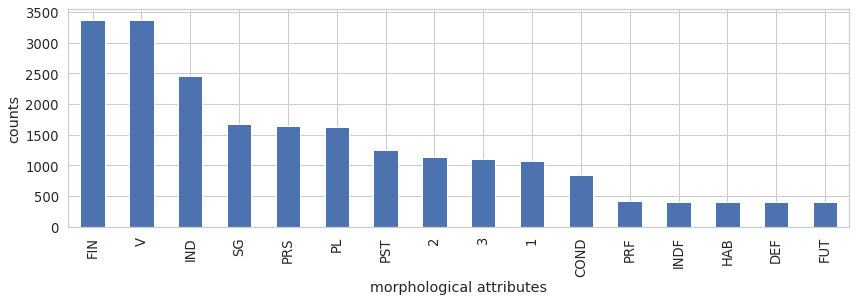

In [8]:
## plot attributes count
fig, ax = plt.subplots(figsize=(14, 4))
df_train_unzip['attributes'].value_counts().plot.bar(ax=ax)
ax.set_xlabel('morphological attributes')
ax.set_ylabel('counts')
plt.show()

**Prefix:** extract the prefix of each lemma from each form will allow us to see which prefix are most correlated with different attributes.

In [55]:
def get_prefix(lemma, form):
    """returns the prefix from the given lemma & form"""
    
    if not lemma in form:
        raise Exception('lemma should be in form')
        
    return form.replace(lemma, '')

In [56]:
## add prefix column to dataframe
df_train_unzip['prefix'] = df_train_unzip.apply(lambda x: get_prefix(x.lemma, x.form), axis=1)
df_train_unzip.head()

,lemma,form,attributes,prefix
0,piga,amepiga,V,ame
1,piga,amepiga,PRF,ame
2,piga,amepiga,FIN,ame
3,piga,amepiga,IND,ame
4,piga,amepiga,SG,ame


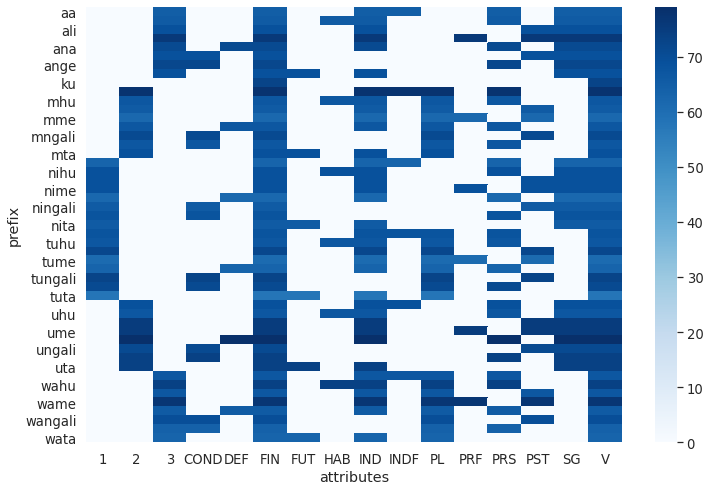

In [57]:
## count number of prefix per attributes
corr = pd.crosstab(index=df_train_unzip['prefix'], columns=df_train_unzip['attributes'])

## display
fig, ax = plt.subplots()
sns.heatmap(corr, ax=ax, cmap='Blues')
plt.show()

**Train & Test data**

In [59]:
## get features & labels for training data
X_train, y_train = df_train_unzip[['lemma', 'form']].to_numpy(), df_train_unzip['attributes'].to_numpy()
X_test = df_train_unzip[['lemma', 'form']].to_numpy()

#### **1.2. Simple baseline to predict morphological attributes**
Now we will write a super simple baseline using 5 rules to predict morphological attributes. This baseline consists of predicting the morphological attribute of a given form and lemma using one of the five rules:
- *Mode*: predict returns the mode of the training labels.
- *prior*: predict returns the prior element of the training labels.
- *stratified* : predict returns an attribute of the training labels in a uniform way.
- *uniform*: predict returns an attribute in a uniform way from unique attributes.
- *constant*: predict returns a constant attribute from the learning labels.

In [67]:
class SimpleBaseline:
    
    """Simple Baseline to predict the morphological attribute of a given lemma and form
    
    Parameters
    ----------
    rule: str,
        The rule to use to predict the attribute.
        
    Attributes
    ----------
    rules: set,
        The set of available rules.
    """
    
    def __init__(self, rule='mode'):
        self.rule = rule
        self.rules = {"mode", "prior", "stratified", "uniform", "constant"}
        
    def fit(self, X, y):
        """fit the model"""
        self.y = y
        
        return self
        
    def predict(self, x):
        """predict the attribute from x"""
        
        if self.rule not in self.rules:
            raise Exception(f'rule should be in {self.rules}')
            
        if self.rule in ['mode', 'prior']:
            y = stats.mode(self.y)[0][0]
            
        elif self.rule == 'uniform':
            y = np.random.choice(np.unique(self.y))
            
        elif self.rule == 'stratified':
            size = np.random.choice(len(set(self.y)))
            y = np.random.choice(self.y, size=size)
            
        elif self.rule == 'constant':
            y = self.y[0]
        
        return y
    
    def __repr__(self):
        return 'SimpleBaseline'

In [72]:
## create a simple baseline
baseline = SimpleBaseline(rule='stratified')

## fir the baseline model
baseline.fit(X_train, y_train)

## test the baseline
baseline.predict(['piga', 'amepiga'])

array(['PL', 'FIN', 'HAB', 'PRS', 'PST', 'DEF', 'FIN', 'V', 'IND', 'PL',
       'IND'], dtype=object)

#### **Prefix-based model**
One can predict using the prefix rule given above, for instance, get the prefix from the given form and lemma, and return the attribute which is most correlated with the prefix.

In [73]:
class PrefixRule:
    """PrefixRule"""
    
    def __init__(self):
        ...
        
    def fit(self, X, y):
        """to fit the model"""
        ## get prefixes
        prefixes = [get_prefix(lemma, form) for lemma, form in X]
        ## unique prefixes
        self.prefixes = set(prefixes)
        ## compute correlation
        df = pd.DataFrame([prefixes, y], index=['prefix', 'attribute']).T
        self.corr = pd.crosstab(df['prefix'], df['attribute'])
        
        return self
        
    def predict(self, x):
        ## get prefix
        lemma, form = x
        prefix = get_prefix(lemma, form)
        
        ## check that prefix is included in the list of prefix
        if prefix not in self.prefixes:
            raise Exception(f'prefix should be in {self.prefixes}')
            
        ## get attributes which are most correlated with prefix
        max_val = self.corr.loc[prefix].max()
        pred_attrs = self.corr.loc[prefix][self.corr.loc[prefix] == max_val].index.to_numpy()
        
        return pred_attrs
    
    def __repr__(self):
        return 'PrefixRule'

In [74]:
## create & fit the model
prefix_rule = PrefixRule()
prefix_rule.fit(X_train, y_train)

PrefixRule

In [75]:
## pick random lemma & form
lemma, form = X_train[np.random.randint(len(X_train))]

## make predictions
pred_attrs = prefix_rule.predict([lemma, form])

print(f"> The predicted attributes for ({lemma}, {form}):\t {', '.join(pred_attrs)}")

## get true attributes
true_attrs = df_train_unzip[(df_train_unzip['lemma'] == lemma) & (df_train_unzip['form'] == form)]['attributes']
print(f"> The true attributes for ({lemma}, {form})\t:\t {', '.join(true_attrs)}")

> The predicted attributes for (inuka, mtainuka):	 2, FIN, FUT, IND, PL, V
> The true attributes for (inuka, mtainuka)	:	 V, FIN, IND, PL, 2, FUT


>**Comments:** 
>- This new model is more interesting because it can predict more than one attribute for a given lemma and form.
>- But one of its main drawbacks is that it only takes into account prefixes that are in the training set.

#### **1.3. Sklearn version**
We will use sklearn to create a few actual models.
To perform machine learning on text documents, we must first transform the text content into numerical feature vectors.

**Bag of Words**

The most intuitive way to do this is to use a *bag-of-words* representation which are high-dimensional sparse datasets:
assign a fixed integer identifier to each word appearing in a document in the learning set.

In [76]:
## instantiate a dictionnary
bag_of_words = {}
unique_lemma = sorted(df_train_unzip['lemma'].unique())

for idx, word in enumerate(unique_lemma):
    bag_of_words[word] = idx
    
## display all in a dataframe
pd.DataFrame(bag_of_words, index=['index'])

,ambia,andika,anguka,anza,bandika,bofya,chafya,changanya,chapisha,cheka,...,tazama,tembea,tengeneza,tikisa,uliza,uwa,uza,vuta,zaa,zima
index,0,1,2,3,4,5,6,7,8,9,...,87,88,89,90,91,92,93,94,95,96


In [77]:
## create a One Hot encoder
enc = OneHotEncoder(handle_unknown='ignore')

## fitting
X = list(zip(bag_of_words.keys(), bag_of_words.values()))
enc.fit(X)

## print categories
enc.categories_

[array(['ambia', 'andika', 'anguka', 'anza', 'bandika', 'bofya', 'chafya',
        'changanya', 'chapisha', 'cheka', 'chimba', 'choma', 'chukia',
        'chukua', 'elewa', 'enda', 'endesha', 'fagia', 'fanya', 'ficha',
        'fika', 'fuata', 'funga', 'fungua', 'funza', 'gonga', 'gusa',
        'imba', 'inua', 'inuka', 'jifunza', 'jisikia', 'jua', 'kaa',
        'kamata', 'kamilisha', 'kata', 'kausha', 'kimbia', 'kohoa', 'kopa',
        'kumbuka', 'kunja', 'kusanya', 'kwaruza', 'lala', 'lamba', 'leta',
        'lia', 'meza', 'mwita', 'ngoja', 'nunua', 'nusa', 'oga', 'ogelea',
        'omba', 'ona', 'ondoa', 'ongea', 'osha', 'ota', 'paa', 'pambua',
        'panda', 'panguza', 'pea', 'piga', 'pika', 'ponda', 'potea',
        'punguza', 'ruka', 'safisha', 'saga', 'saidia', 'sema', 'shikilia',
        'shinda', 'sikiliza', 'simama', 'sinzia', 'soma', 'sukuma',
        'tafuna', 'tafuta', 'taka', 'tazama', 'tembea', 'tengeneza',
        'tikisa', 'uliza', 'uwa', 'uza', 'vuta', 'zaa', 'zima

In [78]:
## transform data
enc.transform(X).toarray()

array([[1., 0., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 0., 1.]])

**Tokenizing text**

Tokenizing is the process of tokenization or division of a string, a text into a list of tokens. 

In [79]:
## create & fit a count vectorizer
count_vect = CountVectorizer()
all_lemma = df_train_unzip['lemma']
X_train_counts = count_vect.fit_transform(all_lemma)
X_train_counts.shape

(21600, 97)

In [80]:
X_train_counts.toarray()

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

**From occurrences to frequencies**
Term Frequency times Inverse Document Frequency

In [81]:
## create & fit a tf transformer
tf_transformer = TfidfTransformer(use_idf=False).fit(X_train_counts)
X_train_tf = tf_transformer.transform(X_train_counts)
X_train_tf.shape

(21600, 97)

In [82]:
tfidf_transformer = TfidfTransformer()
X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)
X_train_tfidf.shape

(21600, 97)

**Create a Classifier**

In [83]:
## create & fit a classifier
clf = MultinomialNB().fit(X_train_tfidf, df_train_unzip['attributes'])

In [84]:
## transform testing data
X_new_counts = count_vect.transform(df_train['form'])
X_new_tfidf = tfidf_transformer.transform(X_new_counts)

## make predictions
predicted = clf.predict(X_new_tfidf)

predicted[:5]

array(['FIN', 'FIN', 'FIN', 'FIN', 'FIN'], dtype='<U4')

### ■ **<a name="actualWork">2. Actual Work</a>** [(&#8593;)](#content)
The purpose of this section si to propose models for the shared-task task 0 problem. To do so, we will use the development data to design two models (a neural and a non neural) that given a lemma and a set of morphological attributes return the corresponding form.

#### **2.1. Neural version**

#### **2.2. Non-Neural version**

**Bag of Words**
Instead of applying bag of words to each word, we will apply it each character as the number of characters is limited and known unlike the number of words.

In [34]:
## bag of words
char_dict = dict(zip(unique_chars, range(1, len(unique_chars)+1)))
inv_char_dict = {n:char for char, n in char_dict.items()}

attr_dict = {attr:i for i, attr in enumerate(unique_attrs, start=1)}
attr_dict

{'GEN': 1,
 'IN+ABL': 2,
 'IPFV': 3,
 'ADJ': 4,
 'IMP': 5,
 'IN+ESS': 6,
 'NOM': 7,
 'IN+ALL': 8,
 'AT+ESS+ALL': 9,
 'COND': 10,
 'SG': 11,
 '2': 12,
 'POT': 13,
 'IND': 14,
 'INS': 15,
 'FRML': 16,
 'AT+ABL': 17,
 'COM': 18,
 'NEG': 19,
 'PL': 20,
 'PST': 21,
 'POS': 22,
 'PRF': 23,
 'ACC': 24,
 'TRANS': 25,
 '1': 26,
 'PRS': 27,
 'NFIN': 28,
 'N': 29,
 '3': 30,
 'PROL': 31,
 'PRT': 32,
 'PRIV': 33,
 'V': 34}

In [35]:
## get all characters in each lemma
train_lemmas = np.array([[[char] for char in lemma] for lemma in df_train['lemma'].to_list()], dtype='object')
test_lemmas = np.array([[[char] for char in lemma] for lemma in df_test['lemma'].to_list()], dtype='object')

## get each attribute
train_attrs = df_train['attributes'].apply(lambda x: x.split(';'))
train_attrs = np.array([[[attr] for attr in set_attrs] for set_attrs in train_attrs], dtype='object')
test_attrs = df_test['attributes'].apply(lambda x: x.split(';'))
test_attrs = np.array([[[attr] for attr in set_attrs] for set_attrs in test_attrs], dtype='object')

## get forms
train_forms = np.array([[[char] for char in form] for form in df_train['form'].to_list()], dtype='object')
test_forms = np.array([[[char] for char in form] for form in df_test['form'].to_list()], dtype='object')

## compute maximum possible characters in a lemma and a form
max_lemma_length = df_train['lemma'].apply(list).apply(len).max()
max_form_length = df_train['form'].apply(lambda x: len(list(x))).max()

## compute maximum possible number of attributes
max_n_attrs = df_train['attributes'].apply(lambda x: len(x.split(';'))).max()

## 
print(f'The maximum possible number of character in a lemma: {max_lemma_length}')
print(f'The maximum possible number of character in a form : {max_form_length}')
print(f'The maximum possible number of attributes for a given lemma & form: {max_n_attrs}')

The maximum possible number of character in a lemma: 16
The maximum possible number of character in a form : 26
The maximum possible number of attributes for a given lemma & form: 7


In [36]:
def pad(array, n, val):
    """to pad a given vector to size n with value val"""
    return np.append(array, np.full(n - len(array), val))

def vect2word(vect):
    word = ''.join([inv_char_dict[i] for i in vect if i])
    return word

def create_trainset(lemmas, forms, attributes, max_lemma, max_form, max_attrs):
    """create a bag of words training set"""
    ## create X and y train
    X_train, y_train = [], []
    for lemma, form, set_attrs in zip(lemmas, forms, attributes):
        x, y = [], []
        
        l = []
        for char in lemma:
            l.append(char_dict[char[0]])
            
        for char in form:
            y.append(char_dict[char[0]])

        at = []
        for attr in set_attrs:
            at.append(attr_dict[attr[0]])


        x = np.append(pad(l, max_lemma, 0), pad(at, max_attrs, 0))
        X_train.append(x)
        y_train.append(pad(y, max_form, 0))
        
    return X_train, y_train

## get training & test set
X_train, y_train = create_trainset(train_lemmas, train_forms, train_attrs, max_lemma_length, max_form_length, max_n_attrs)
X_test, y_test = create_trainset(test_lemmas, test_forms, test_attrs, max_lemma_length, max_form_length, max_n_attrs)

In [ ]:
## create & fit an RF model
clf = RandomForestClassifier(random_state=0)
clf.fit(X_train, y_train)

## make predictions
y_pred = clf.predict(X_test)

## vects to words
words_predictions = [vect2word(vect) for vect in y_pred]
words_test = [vect2word(vect) for vect in y_test]

## accuracy
word_accuracy = eval_acc(words_predictions, words_test)
word_accuracy

In [21]:
## character accuracy
char_accuracy = 0
total_chars = 0
for word1, word2 in zip(words_predictions, words_test):
    char_accuracy += len(word1) - distance(word1, word2)
    total_chars += len(word1)
    
char_accuracy / total_chars

0.8326843514237041

In [ ]:
def bag_of_words_pipeline(train_file, test_file, verbose=1):
    ## dataframe
    df_train = read_file(train_file)
    df_test = read_file(test_file)

    ## number of training & testing samples
    n_train = df_train.shape[0]
    n_test = df_test.shape[0]
    if verbose:
        print(f'Number of training samples: {n_train}')
        print(f'Number of testing samples : {n_test}')*
    
    ## get the number of unique characters
    text = ''.join(df_train[['lemma', 'form']].to_numpy().flatten())

    ## get (number of) unique characters
    unique_chars = set(text)
    n_chars = len(unique_chars)
    
    ## get unique morphological attributes
    morph_attrs = ';'.join(df_train['attributes'].to_list()).split(';')
    morph_attrs = np.asarray(morph_attrs)
    unique_attrs = set(morph_attrs)
    n_attrs = len(unique_attrs)
    
    if verbose:
        print(f"> Number of unique characters: {n_chars}\n> Characters: {', '.join(unique_chars)}")
        print(f"> Number of unique morphological attributes: {n_attrs}\n> Morphological attributes: {', '.join(unique_attrs)}")
    
    ## bag of words
    char_dict = dict(zip(unique_chars, range(1, len(unique_chars)+1)))
    inv_char_dict = {n:char for char, n in char_dict.items()}

    attr_dict = {attr:i for i, attr in enumerate(unique_attrs, start=1)}
    
    ## get all characters in each lemma
    train_lemmas = np.array([[[char] for char in lemma] for lemma in df_train['lemma'].to_list()], dtype='object')
    test_lemmas = np.array([[[char] for char in lemma] for lemma in df_test['lemma'].to_list()], dtype='object')

    ## get each attribute
    train_attrs = df_train['attributes'].apply(lambda x: x.split(';'))
    train_attrs = np.array([[[attr] for attr in set_attrs] for set_attrs in train_attrs], dtype='object')
    test_attrs = df_test['attributes'].apply(lambda x: x.split(';'))
    test_attrs = np.array([[[attr] for attr in set_attrs] for set_attrs in test_attrs], dtype='object')

    ## get forms
    train_forms = np.array([[[char] for char in form] for form in df_train['form'].to_list()], dtype='object')
    test_forms = np.array([[[char] for char in form] for form in df_test['form'].to_list()], dtype='object')

    ## compute maximum possible characters in a lemma and a form
    max_lemma_length = df_train['lemma'].apply(list).apply(len).max()
    max_form_length = df_train['form'].apply(lambda x: len(list(x))).max()

    ## compute maximum possible number of attributes
    max_n_attrs = df_train['attributes'].apply(lambda x: len(x.split(';'))).max()

    ## 
    if verbose:
        print(f'The maximum possible number of character in a lemma: {max_lemma_length}')
        print(f'The maximum possible number of character in a form : {max_form_length}')
        print(f'The maximum possible number of attributes for a given lemma & form: {max_n_attrs}')
    
    ## get training & test set
    X_train, y_train = create_trainset(train_lemmas, train_forms, train_attrs, max_lemma_length, max_form_length, max_n_attrs)
    X_test, y_test = create_trainset(test_lemmas, test_forms, test_attrs, max_lemma_length, max_form_length, max_n_attrs)
    
    ## create & fit an RF model
    clf = RandomForestClassifier(random_state=0)
    clf.fit(X_train, y_train)

    ## make predictions
    y_pred = clf.predict(X_test)

    ## vects to words
    words_predictions = [vect2word(vect) for vect in y_pred]
    words_test = [vect2word(vect) for vect in y_test]

    ## accuracy
    word_accuracy = eval_acc(words_predictions, words_test)
    
    ## character accuracy
    char_accuracy = 0
    total_chars = 0
    for word1, word2 in zip(words_predictions, words_test):
        char_accuracy += len(word1) - distance(word1, word2)
        total_chars += len(word1)
    
    print(f'word accuracy     : {word_accuracy}')
    print(f'character accuracy: {char_accuracy / total_chars}')

#### **OneHot encoding**

In [85]:
## create a One Hot encoder
enc_lemmas = OneHotEncoder(handle_unknown='ignore')

## fitting
x = np.array(list(unique_chars)).reshape(-1, 1)
enc_lemmas.fit(x)

## print categories
enc_lemmas.categories_

[array(['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm',
        'n', 'o', 'p', 'r', 's', 't', 'u', 'v', 'w', 'y', 'z'], dtype='<U1')]

In [88]:
## create a One Hot encoder
enc_attrs = OneHotEncoder(handle_unknown='ignore')

## fitting
x = morph_attrs.reshape(-1, 1)
enc_attrs.fit(x)

## print categories
enc_attrs.categories_

[array(['1', '2', '3', 'COND', 'DEF', 'FIN', 'FUT', 'HAB', 'IND', 'INDF',
        'PL', 'PRF', 'PRS', 'PST', 'SG', 'V'], dtype='<U4')]

In [106]:
def compelete_array(array, l):
    comp = np.zeros((l - array.shape[0], array.shape[1]))
    
    return np.vstack((array, comp))


X_train = []

for lemma, set_attrs in tqdm(zip(lemmas, attrs)):
    
    lemma_tr = enc_lemmas.transform(lemma).toarray()
    attr_tr = enc_attrs.transform(set_attrs).toarray()
    
    lemma_tr = compelete_array(lemma_tr, max_lemma_length)
    attr_tr = compelete_array(attr_tr, max_attrs)
    
    
    X_train.append(lemma_tr)

3504it [00:02, 1495.07it/s]


KeyboardInterrupt: 

In [22]:
lemma_tr.shape, attr_tr.shape

((16, 41), (2, 4))

14

In [20]:
y_train = []



# for form in forms:
#     form_tr = enc_lemmas.transform(form).toarray()
    
#     form_tr = compelete_array(form_tr, 18)
    
#     y_train.append(form_tr)

### **References** 
@article{vylomova2020sigmorphon, title={SIGMORPHON 2020 Shared Task 0: Typologically Diverse Morphological Inflection}, author={Vylomova, Ekaterina and White, Jennifer and Salesky, Elizabeth and Mielke, Sabrina J and Wu, Shijie and Ponti, Edoardo and Maudslay, Rowan Hall and Zmigrod, Ran and Valvoda, Josef and Toldova, Svetlana and others}, journal={SIGMORPHON 2020}, pages={1}, year={2020} }

---
<p style="text-align: center;">Copyright © 2021 Omar Ikne & Zakaria Boulkhir</p>